In this notebook, we'll identify any lidar clips that do not completely cover the inventory plot and copy any nearly-complete coverage plots to our processed data folder.

In [1]:
import geopandas as gpd
import pandas as pd
import glob
import shutil
import os
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# USFS Region 6 Albers Equal Area Map Projection, proj4 string format
# we'll use this later for calculating the area of each plot
USFS_ALB = '+proj=aea +lat_1=41 +lat_2=47 +lat_0=44 +lon_0=-120 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

In [3]:
PLOT_LOCATIONS = '../data/processed/blm_usfs_wadnr_plot_footprints.shp'
plot_locs = gpd.read_file(PLOT_LOCATIONS).set_index('uuid')
plot_locs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5089 entries, d7c01e3a-38e0-4bc2-a69c-7d5a204e2663 to 4214cf54-1e3f-45d3-b93c-80c965cb3314
Data columns (total 9 columns):
comments     496 non-null object
lat          5089 non-null float64
lon          5089 non-null float64
meas_date    3866 non-null object
orig_id      5089 non-null object
plot_id      3866 non-null object
source       5089 non-null object
meas_yr      5089 non-null int64
geometry     5089 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 397.6+ KB


In [4]:
PLOT_CLIPS = '../data/interim/lidar/plot_clips/'

In [5]:
ha_clip_dirs = [x for x,_,_ in os.walk(PLOT_CLIPS) if 'hectare_clips' in x]
ha_clip_dirs

['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/blm_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/noaa/dnr_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/osu/usfs_plots/hectare_clips',
 '../data/interim/lidar/plot_clips/osu/blm_plots/hectare_clips']

In [6]:
plot_clip_dirs = [x for x,_,_ in os.walk(PLOT_CLIPS) if 'plot_clips' in x.split('/')[-1]]
plot_clip_dirs

['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/blm_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/noaa/dnr_plots/plot_clips',
 '../data/interim/lidar/plot_clips/osu/usfs_plots/plot_clips',
 '../data/interim/lidar/plot_clips/osu/blm_plots/plot_clips']

In [7]:
shps = glob.glob(os.path.join(ha_clip_dirs[0], '*.shp'))
len(shps)

105

In [8]:
dnr_plots = [d for d in plot_clip_dirs if 'dnr_plots' in d]
dnr_hectares = [d for d in ha_clip_dirs if 'dnr_plots' in d]
dnr_plots, dnr_hectares

(['../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/plot_clips',
  '../data/interim/lidar/plot_clips/noaa/dnr_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/dnr_portal/dnr_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/noaa/dnr_plots/hectare_clips'])

In [9]:
blm_plots = [d for d in plot_clip_dirs if 'blm_plots' in d]
blm_hectares = [d for d in ha_clip_dirs if 'blm_plots' in d]
blm_plots, blm_hectares

(['../data/interim/lidar/plot_clips/noaa/blm_plots/plot_clips',
  '../data/interim/lidar/plot_clips/osu/blm_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/noaa/blm_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/osu/blm_plots/hectare_clips'])

In [10]:
usfs_plots = [d for d in plot_clip_dirs if 'usfs_plots' in d]
usfs_hectares = [d for d in ha_clip_dirs if 'usfs_plots' in d]
usfs_plots, usfs_hectares

(['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/plot_clips',
  '../data/interim/lidar/plot_clips/noaa/usfs_plots/plot_clips',
  '../data/interim/lidar/plot_clips/osu/usfs_plots/plot_clips'],
 ['../data/interim/lidar/plot_clips/dnr_portal/usfs_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/noaa/usfs_plots/hectare_clips',
  '../data/interim/lidar/plot_clips/osu/usfs_plots/hectare_clips'])

In [11]:
usfs_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in usfs_plots]
# flatten the list of shapefiles
usfs_plot_shps = [shp for shps in usfs_plot_shps for shp in shps]
len(usfs_plot_shps)

647

In [12]:
blm_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in blm_plots]
# flatten the list of shapefiles
blm_plot_shps = [shp for shps in blm_plot_shps for shp in shps]
len(blm_plot_shps)

1435

In [13]:
dnr_plot_shps = [glob.glob(os.path.join(d,'*.shp')) for d in dnr_plots]
# flatten the list of shapefiles
dnr_plot_shps = [shp for shps in dnr_plot_shps for shp in shps]
len(dnr_plot_shps)

4120

In [14]:
dnr_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in dnr_plot_shps]
dnr_plot_gdf = pd.concat(dnr_plot_gdfs, axis=0, ignore_index=True, sort=True)
dnr_plot_gdf['area_m2'] = dnr_plot_gdf.to_crs(USFS_ALB).area
dnr_plot_gdf['acres'] = dnr_plot_gdf['area_m2'] / 4046.86
dnr_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4115 entries, 0 to 4114
Data columns (total 14 columns):
file_name     4115 non-null object
geometry      4115 non-null object
max_x         4115 non-null float64
max_y         4115 non-null float64
max_z         4115 non-null float64
min_x         4115 non-null float64
min_y         4115 non-null float64
min_z         4115 non-null float64
num_points    4115 non-null float64
point_size    4115 non-null float64
point_type    4115 non-null float64
version       4115 non-null object
area_m2       4115 non-null float64
acres         4115 non-null float64
dtypes: float64(11), object(3)
memory usage: 450.2+ KB


In [15]:
basenames = [os.path.basename(shp).split('.')[0] for shp in dnr_plot_shps]
missing = [x for x in basenames if x not in dnr_plot_gdf.file_name.apply(lambda x: x.split('.')[0]).values]
len(missing), len(basenames)

(5, 4120)

In [16]:
missing

['7af6509c-cb39-4d2f-ab59-08e88c6928ac_clallam-county_2001-2002',
 'bc9db40a-ca12-48bb-bd32-be8f51d49cb7_kitsap_2000',
 '81c6c096-2710-4374-b848-0b209ca72a0c_kitsap_2000',
 'b8d0b1b7-ddfe-44b1-9815-ebccf994e3c2_kitsap_2000',
 '0aa62f02-d7a0-45df-86ed-49f94e5b0e67_kitsap_2000']

In [17]:
def get_wild_file(path):
    dirname, basename = os.path.split(path)
    return os.path.join(dirname, basename.split('.')[0]+'.*')

In [18]:
paths = [get_wild_file(x) for x in dnr_plot_shps if os.path.basename(x).split('.')[0] not in missing]
dnr_plot_gdf['path'] = paths

In [19]:
# keep the plot clip that has the largest lidar coverage area among duplicates
dnr_plot_gdf = dnr_plot_gdf.sort_values(by=['file_name', 'acres']).drop_duplicates(subset='file_name', keep='last')

In [20]:
usfs_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in usfs_plot_shps]
usfs_plot_gdf = pd.concat(usfs_plot_gdfs, axis=0, ignore_index=True, sort=True)
usfs_plot_gdf['path'] = [get_wild_file(f) for f in usfs_plot_shps]
usfs_plot_gdf['area_m2'] = usfs_plot_gdf.to_crs(USFS_ALB).area
usfs_plot_gdf['acres'] = usfs_plot_gdf['area_m2'] / 4046.86
usfs_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 15 columns):
file_name     647 non-null object
geometry      647 non-null object
max_x         647 non-null float64
max_y         647 non-null float64
max_z         647 non-null float64
min_x         647 non-null float64
min_y         647 non-null float64
min_z         647 non-null float64
num_points    647 non-null int64
point_size    647 non-null int64
point_type    647 non-null int64
version       647 non-null object
path          647 non-null object
area_m2       647 non-null float64
acres         647 non-null float64
dtypes: float64(8), int64(3), object(4)
memory usage: 75.9+ KB


In [21]:
blm_plot_gdfs = [gpd.read_file(shp).to_crs({'init':'epsg:4326'}) for shp in blm_plot_shps]
blm_plot_gdf = pd.concat(blm_plot_gdfs, axis=0, ignore_index=True, sort=True)
blm_plot_gdf['path'] = [get_wild_file(f) for f in blm_plot_shps]
blm_plot_gdf['area_m2'] = blm_plot_gdf.to_crs(USFS_ALB).area
blm_plot_gdf['acres'] = blm_plot_gdf['area_m2'] / 4046.86
blm_plot_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 15 columns):
file_name     1435 non-null object
geometry      1435 non-null object
max_x         1435 non-null float64
max_y         1435 non-null float64
max_z         1435 non-null float64
min_x         1435 non-null float64
min_y         1435 non-null float64
min_z         1435 non-null float64
num_points    1435 non-null int64
point_size    1435 non-null int64
point_type    1435 non-null int64
version       1435 non-null object
path          1435 non-null object
area_m2       1435 non-null float64
acres         1435 non-null float64
dtypes: float64(8), int64(3), object(4)
memory usage: 168.2+ KB


In [22]:
def display_thresh(plot_gdf, thresh_pct, plot_size_ac):
    below_thresh = plot_gdf.loc[plot_gdf.acres < (thresh_pct* plot_size_ac)].sort_values(by='acres', ascending=False).iloc[0:10]
    above_thresh = plot_gdf.loc[plot_gdf.acres >= (thresh_pct* plot_size_ac)].sort_values(by='acres', ascending=True).iloc[0:10]
    fig, axs = plt.subplots(2, max(len(above_thresh), len(below_thresh), 10),
                       figsize=(10,2.5))
                               
    for i in range(len(above_thresh)):
        above_thresh.iloc[[i]].to_crs(USFS_ALB).plot(ax=axs[0, i])
        plot_id = above_thresh.iloc[i].file_name.split('_')[0]
        plot_locs.loc[[plot_id]].centroid.to_crs(USFS_ALB).plot(ax=axs[0, i], color='black')
        plot_locs.loc[[plot_id]].to_crs(USFS_ALB).plot(ax=axs[0, i], edgecolor='black', facecolor='none')
        axs[0, i].set_yticks([])
        axs[0, i].set_xticks([])
        for spine in axs[0,i].spines.values():
            spine.set_visible(False)
        axs[0, i].set_title('{:.1%}'.format(above_thresh.iloc[i].acres/PLOT_SIZE_AC))

    for i in range(len(below_thresh)):
        below_thresh.iloc[[i]].to_crs(USFS_ALB).plot(ax=axs[1, i], color='red')
        plot_id = below_thresh.iloc[i].file_name.split('_')[0]
        plot_locs.loc[[plot_id]].centroid.to_crs(USFS_ALB).plot(ax=axs[1, i], color='black')
        plot_locs.loc[[plot_id]].to_crs(USFS_ALB).plot(ax=axs[1, i], edgecolor='black', facecolor='none')
        axs[1, i].set_yticks([])
        axs[1, i].set_xticks([])
        for spine in axs[1,i].spines.values():
            spine.set_visible(False)
        axs[1, i].set_title('{:.1%}'.format(below_thresh.iloc[i].acres/PLOT_SIZE_AC))

    axs[0,0].set_ylabel('ACCEPT')
    axs[1,0].set_ylabel('REJECT')
    plt.show()

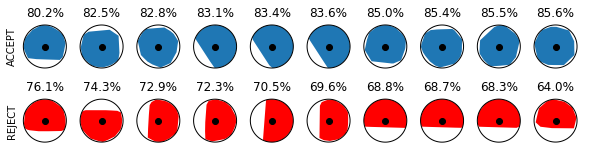

In [23]:
THRESH_PCT = 0.80
PLOT_SIZE_AC = 1/10
display_thresh(dnr_plot_gdf, thresh_pct=THRESH_PCT, plot_size_ac=PLOT_SIZE_AC)

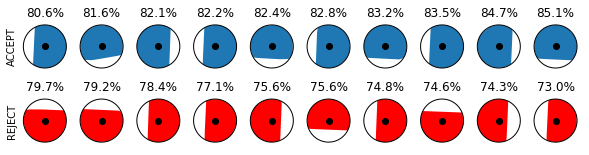

In [24]:
THRESH_PCT = 0.80
PLOT_SIZE_AC = 1/8
display_thresh(blm_plot_gdf, thresh_pct=THRESH_PCT, plot_size_ac=PLOT_SIZE_AC)

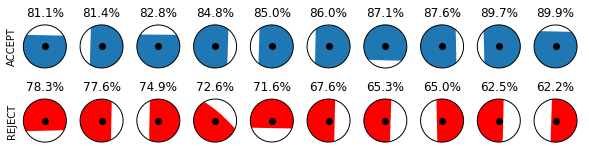

In [25]:
THRESH_PCT = 0.80
PLOT_SIZE_AC = 1/4
display_thresh(usfs_plot_gdf, thresh_pct=THRESH_PCT, plot_size_ac=PLOT_SIZE_AC)

In [26]:
# drop plots that have more than 20% of the plot area missing from the point cloud
THRESH_PCT = 0.8
dnr_accepted_plots = dnr_plot_gdf.loc[dnr_plot_gdf.acres >= (THRESH_PCT* 1/10)]
blm_accepted_plots = blm_plot_gdf.loc[blm_plot_gdf.acres >= (THRESH_PCT * 1/8)]
usfs_accepted_plots = usfs_plot_gdf.loc[usfs_plot_gdf.acres >= (THRESH_PCT * 1/4)]

In [27]:
print('ALL PLOTS: \tDNR: {:,}\tBLM: {:,}\tUSFS: {:,}'.format(
    len(dnr_plot_gdf), len(blm_plot_gdf), len(usfs_plot_gdf)))
print('ACCEPTED: \tDNR: {:,}\tBLM: {:,}\tUSFS: {:,}'.format(
    len(dnr_accepted_plots), len(blm_accepted_plots), len(usfs_accepted_plots)))

ALL PLOTS: 	DNR: 3,138	BLM: 1,435	USFS: 647
ACCEPTED: 	DNR: 3,110	BLM: 1,398	USFS: 627


In [28]:
usfs_accepted_plots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 627 entries, 0 to 646
Data columns (total 15 columns):
file_name     627 non-null object
geometry      627 non-null object
max_x         627 non-null float64
max_y         627 non-null float64
max_z         627 non-null float64
min_x         627 non-null float64
min_y         627 non-null float64
min_z         627 non-null float64
num_points    627 non-null int64
point_size    627 non-null int64
point_type    627 non-null int64
version       627 non-null object
path          627 non-null object
area_m2       627 non-null float64
acres         627 non-null float64
dtypes: float64(8), int64(3), object(4)
memory usage: 78.4+ KB


In [29]:
def get_hec_path(plot_path):
    dirname, basename = os.path.split(plot_path)
    hec_dir = os.path.abspath(os.path.join(dirname, '..', 'hectare_clips'))
    return os.path.join(hec_dir, basename)

In [30]:
# move the remaining plot clips to the accepted plots directory
def move_plots(plot_gdf, dest):
    for p in plot_gdf.path:
        for f in glob.glob(p):
            shutil.copy(f, dest)
        for f in glob.glob(get_hec_path(p)):
            shutil.copy(f, get_hec_path(dest))

    moved = glob.glob(os.path.join(dest,'*.laz'))
    print('Copied {} laz files to {}'.format(len(moved), dest))

In [31]:
DEST = '../data/interim/lidar/accepted_plot_clips/dnr_plots/plot_clips/'
PLOT_GDF = dnr_accepted_plots
move_plots(PLOT_GDF, DEST)

Moved 3110 laz files to ../data/interim/lidar/accepted_plot_clips/dnr_plots/plot_clips/


In [32]:
DEST = '../data/interim/lidar/accepted_plot_clips/blm_plots/plot_clips/'
PLOT_GDF = blm_accepted_plots
move_plots(PLOT_GDF, DEST)

Moved 1398 laz files to ../data/interim/lidar/accepted_plot_clips/blm_plots/plot_clips/


In [33]:
DEST = '../data/interim/lidar/accepted_plot_clips/usfs_plots/plot_clips/'
PLOT_GDF = usfs_accepted_plots
move_plots(PLOT_GDF, DEST)

Moved 627 laz files to ../data/interim/lidar/accepted_plot_clips/usfs_plots/plot_clips/


In [36]:
dnr_accepted_plots.to_file('../data/interim/lidar/accepted_plot_clips/dnr_plots/dnr_plots_lidar_coverage.shp')
blm_accepted_plots.to_file('../data/interim/lidar/accepted_plot_clips/blm_plots/blm_plots_lidar_coverage.shp')
usfs_accepted_plots.to_file('../data/interim/lidar/accepted_plot_clips/usfs_plots/usfs_plots_lidar_coverage.shp')